In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster( walltime='3:00:00')
#w = cluster.scale(5*14)
w = cluster.scale(1*14)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.39:56147 Dashboard: http://10.148.0.39:8787/status,Cluster Workers: 7 Cores: 7 Memory: 119.98 GB


---


# 1. Drifter data files

In [5]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'

drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     157978*1
# mlon2: mean longitude over 60 days,    157978*1

# qd: drogued drifters,                  157978*1
# qmed200: median water depth > 200 m,   157978*1
# qu: undrogued drifters,                157978*1

# uv2: (u, v),                           157978*1440

[('dpth2', <HDF5 dataset "dpth2": shape (157978, 1440), type "<f8">),
 ('lat2_err', <HDF5 dataset "lat2_err": shape (157978, 1440), type "<f8">),
 ('lon2_err', <HDF5 dataset "lon2_err": shape (157978, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (157978, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (157978, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (157978, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (157978, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (157978, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (157978, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (157978, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (157978, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (157978, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (157978, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (157978, 1), type "|u1">),
 ('u2_err', <HDF5 dataset

In [6]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 157978)>
array([ 44.21985334,  44.90892815,  44.85686269, ..., -37.52456321,
       -37.17136608, -37.19408437])
Dimensions without coordinates: lat

In [7]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 157978)>
array([307.99270714, 306.96272235, 305.59750069, ..., 325.84482835,
       326.13866791, 325.50641353])
Dimensions without coordinates: lon

In [8]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 157978)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [9]:
# (u,v) --> u+iv
uv = np.array(drifter_dataset['uv2']).view(np.double).reshape((157978, 1440, 2))
uv_drifters = uv[:,:,0] + 1j*uv[:,:,1]
uv_drifters.shape  # result is (10, 10, 10)
uv_drifters

array([[-0.2048+0.4936j, -0.3023+0.4859j, -0.2971+0.4856j, ...,
         0.1322+0.009j ,  0.1219-0.0239j, -0.0805-0.1172j],
       [ 0.1436+0.2085j,  0.1056+0.1783j,  0.0387+0.128j , ...,
         0.116 +0.075j ,  0.0779+0.2255j,  0.1379+0.195j ],
       [-0.1518-0.1663j, -0.1137-0.1704j, -0.1083-0.1446j, ...,
        -0.2145-0.3872j, -0.215 -0.3862j, -0.2145-0.3976j],
       ...,
       [ 0.3967+0.1554j,  0.4447+0.1624j,  0.4864+0.1736j, ...,
         0.072 +0.2357j,  0.0712+0.2299j,  0.0676+0.2051j],
       [ 0.1061+0.0992j,  0.074 +0.0919j,  0.0629+0.096j , ...,
         0.0589+0.0466j,  0.0513+0.0552j,  0.0395+0.0682j],
       [ 0.0622+0.164j ,  0.0589+0.1348j,  0.0671+0.121j , ...,
        -0.1189+0.0092j, -0.1027-0.0244j, -0.0739-0.0525j]])

In [10]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'uv_drifters': (['lat', 'time'], uv_drifters)},
                
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 157978, time: 1440)
Coordinates:
  * lat          (lat) float64 44.22 44.91 44.86 43.76 ... -37.52 -37.17 -37.19
    lon          (lat) float64 308.0 307.0 305.6 305.5 ... 325.8 326.1 325.5
  * time         (time) int64 0 3600 7200 10800 ... 5173200 5176800 5180400
    qd           (lat) uint8 1 1 1 1 1 0 0 0 1 1 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
Data variables:
    uv_drifters  (lat, time) complex128 (-0.2048+0.4936j) ... (-0.0739-0.0525j)

 data size: 3.6 GB


_________
# 2. Rotary spectra of Drifter uv

## raw drogued drifters

## linear detrending and Hanning windowing

### Drogued drifters

In [50]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd==0).fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)#/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_blocks 

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xrft/xrft.py:336: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


<xarray.DataArray 'E_uv_blocks' (lat: 157978, freq_time: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat        (lat) float64 44.22 44.91 44.86 43.76 ... -37.52 -37.17 -37.19
    lon        (lat) float64 308.0 307.0 305.6 305.5 ... 321.4 325.8 326.1 325.5
    qd         (lat) uint8 1 1 1 1 1 0 0 0 1 1 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * freq_time  (freq_time) float64 0.0 1.929e-07 ... -3.858e-07 -1.929e-07
    freq_cpd   (freq_time) float64 0.0 0.01667 0.03333 ... -0.03333 -0.01667

In [51]:
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_linear_window = E_uv_zonmean#.load()
E_drifter_linear_window = np.real(E_drifter_linear_window).rename('E_drifter_linear_window')
E_drifter_linear_window

<xarray.DataArray 'E_drifter_linear_window' (lat_bins: 121, freq_time: 1440)>
array([[1034.174897  , 2119.9695414 , 2927.32512084, ..., 2753.62789269,
        3259.54496164, 2424.83565485],
       [1026.35547217, 2164.93099111, 2872.56980244, ..., 2778.06461598,
        3158.14408292, 2262.9937413 ],
       [1125.46098696, 2209.5500306 , 2836.37260647, ..., 2869.15121582,
        3170.00478818, 2517.98875074],
       ...,
       [ 896.19346013, 1983.99127501, 2212.19225934, ..., 2120.13808471,
        2431.28399853, 1709.01010136],
       [1083.90584808, 2683.37282147, 3228.89877823, ..., 2331.05816151,
        2346.95579999, 1737.22543405],
       [1198.98615315, 2629.50816765, 3114.49542769, ..., 2440.6888998 ,
        2606.43020011, 2062.2842571 ]])
Coordinates:
  * lat_bins   (lat_bins) int64 -60 -59 -58 -57 -56 -55 ... 55 56 57 58 59 60
  * freq_time  (freq_time) float64 0.0 1.929e-07 ... -3.858e-07 -1.929e-07
    freq_cpd   (freq_time) float64 0.0 0.01667 0.03333 ... -0.03333 -0.01667

Text(0.5, 1.0, 'Drifter')

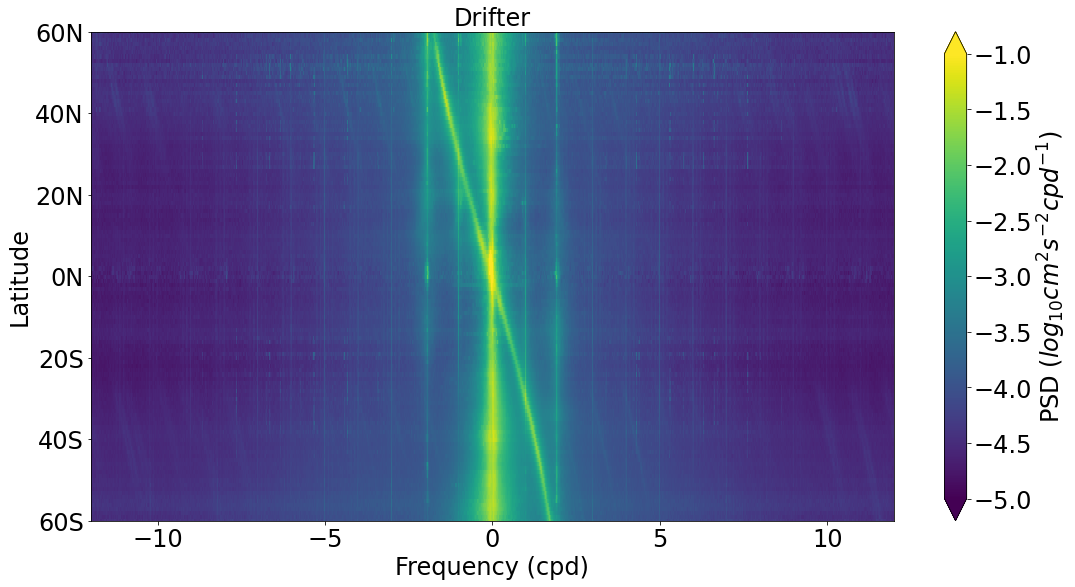

In [55]:
plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

cax = np.log10(E_drifter_linear_window.sortby('freq_time')/86400).plot.pcolormesh(ax=ax, vmin=-5., vmax=-1, x='freq_cpd', y='lat_bins', cmap = 'viridis', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=24)
            
# x,y ticks
ax.set_xlim(-12., 12.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifter',fontsize=24)


In [46]:
from scipy.signal import welch

# spatial strides for decimation
def _get_E(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = welch(x, fs=24., axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    v = v.chunk({'time': len(v.time)})
    if 'nperseg' in kwargs:
        Nb = kwargs['nperseg']
    else:
        Nb = 60*24
        kwargs['nperseg']= Nb
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')


# spectral computation
# need to run once to get frequency line
f, E = get_E(ds['uv_drifters'].isel(lat=2))
#
E = get_E(ds.uv_drifters.where(ds.qd==0).fillna(0.), f=f)        
E

<ipython-input-46-dd07685a5ddd>:28: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E, v,
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'uv_drifters' (lat: 157978, freq_time: 1440)>
dask.array<getitem, shape=(157978, 1440), dtype=float64, chunksize=(157978, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 44.22 44.91 44.86 43.76 ... -37.52 -37.17 -37.19
    lon        (lat) float64 dask.array<chunksize=(157978,), meta=np.ndarray>
    qd         (lat) uint8 dask.array<chunksize=(157978,), meta=np.ndarray>
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98

In [47]:
E_uv_zonmean = (E.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_linear_window = E_uv_zonmean#.load()
E_drifter_linear_window = np.real(E_drifter_linear_window).rename('E_drifter_linear_window')
E_drifter_linear_window

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'E_drifter_linear_window' (lat_bins: 121, freq_time: 1440)>
dask.array<real, shape=(121, 1440), dtype=float64, chunksize=(1, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat_bins   (lat_bins) int64 -60 -59 -58 -57 -56 -55 ... 55 56 57 58 59 60
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98

In [ ]:
plt.figure(figsize=(18,9))
ax = plt.subplot(1,1,1)

cax = np.log10(E_drifter_linear_window.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=-1., vmax=3.5, x='freq_time', y='lat_bins', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=24)
            
# x,y ticks
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])
ax.set_ylabel('Latitude',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifter',fontsize=24)


In [30]:
latb = np.arange(-60.,60.,1.)
latc = (latb[:-1]+latb[1:])*.5

def _zhist(x, lat, weights=True):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    if weights:
        w = x
    else:
        w = np.ones_like(x)
    h, edges = np.histogram(lat, bins=latb, weights=w, density=False)
    return h[None,:]

def zaverage(v):
    dims = ['lat']
    v = v.fillna(0.)
    lat = v.lat+0.*v
    #
    S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    S = S.assign_coords(latitude=latc).rename('S_SSUV')
    #
    W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    W = W.assign_coords(latitude=latc).rename('W_SSUV')    
    return xr.merge([S, W], compat='identical')

In [31]:
Eds = zaverage(E).chunk({'freq_time':None})
Eds

<ipython-input-30-c0751bfd5d28>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-30-c0751bfd5d28>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


<xarray.Dataset>
Dimensions:    (freq_time: 1440, latitude: 119)
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
Data variables:
    S_SSUV     (freq_time, latitude) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>
    W_SSUV     (freq_time, latitude) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>

In [32]:
E_zav = (Eds.S_SSUV/Eds.W_SSUV).rename('E_SSUV')
print(E_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [ ]:
E_zav.isel(latitude=1).plot()

In [22]:
#E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 

E_uv_zonmean = (E.groupby_bins(E.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))
E_uv_zonmean

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'uv_drifters' (lat_bins: 121, freq_time: 1440)>
dask.array<getitem, shape=(121, 1440), dtype=float64, chunksize=(1, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat_bins   (lat_bins) int64 -60 -59 -58 -57 -56 -55 ... 55 56 57 58 59 60
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98

In [ ]:
E_uv_zonmean.plot()

In [56]:
cluster.close()